In [1]:
import time
import pandas as pd
import numpy as np
from scipy.stats import uniform
import matplotlib.pyplot as plt
import matplotlib_inline
import seaborn as sns
import mglearn

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

# import helperfunctions
from helperfunctions_models import fun_load_file, fun_preprocessing, fun_split_X_y
from helperfunctions_models import fun_convert_time, fun_fit_gridsearch_time
from helperfunctions_models import fun_train_score, fun_test_score, fun_best_model
from helperfunctions_models import plot_feature_importances

# start time count and load data
start_script = time.time()
data = fun_load_file(subfolder_path='..\\01_data\\01_TSP', name='tsp_instances_j_updated.xlsx')
train_data = fun_preprocessing(data)
X, y = fun_split_X_y(train_data)

# create a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# save number of features and train sizes
n_features = X_train.shape[1]
train_size = f'{int(np.round(100 * len(X_train)/len(X)))} %'

# **Ensebmles of Decision Trees**
### **Random Forest**

In [2]:
# randomized grid search cross validation
param_distributions = {'max_features': range(15, n_features+1),
                       'max_depth': range(10, 25),
                       'max_leaf_nodes': range(1200, 1700),
                       'min_samples_leaf': range(1, 25),
                       'min_impurity_decrease': uniform(0, 0.005)}

random_grid_search = RandomizedSearchCV(estimator=RandomForestRegressor(n_estimators=50, bootstrap=True, random_state=0, n_jobs=-1, verbose=False),
                                        param_distributions=param_distributions, cv=3, 
                                        n_iter=100, scoring='neg_mean_absolute_percentage_error',
                                        random_state=0, n_jobs=-1, verbose=False)
fit_time = fun_fit_gridsearch_time(random_grid_search, X_train, y_train)

# view results of grid search cross validation
MAPE, RMSE = fun_best_model(random_grid_search, X_train, y_train, view_results_df=False, return_scores=True)

# save results to dictionary
results_dict = {}
results_dict['Random Forest (RGS)'] = {'MAPE': MAPE, 'RMSE': RMSE, 'Fit grid searach time': fit_time, 'CV computation time': None, 'Train size': train_size}

  CV MAPE train data: 7.556699999999999 %
  CV RMSE train data: 1.7244

  Best model / parameter combination:


RandomForestRegressor(max_depth=21, max_features=19, max_leaf_nodes=1623,
                      min_impurity_decrease=0.0005876592798101654,
                      min_samples_leaf=11, n_estimators=50, n_jobs=-1,
                      random_state=0, verbose=False)

**Create new model with best parameters**

In [3]:
# random_grid_search.best_params_
best_params_ = {'max_depth': 17,
               'max_features': 27,
               'max_leaf_nodes': 1488,
               'min_impurity_decrease': 0.0007957311847112142,
               'min_samples_leaf': 12}

In [4]:
# train new model with best parameter combination but more trees
forest = RandomForestRegressor(n_estimators=200, **random_grid_search.best_params_, #best_params_
                               bootstrap=True, random_state=0, n_jobs=-1, verbose=False)

# estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
MAPE, RMSE, computation_time = fun_train_score(forest, X_train, y_train, cv=5, return_results=True)

# save results to dictionary
results_dict['Random Forest (Best model, more trees)'] = {'MAPE': MAPE, 'RMSE': RMSE, 'CV computation time': computation_time, 'Train size': train_size}

  CV MAPE train data:  7.5048 %
  CV RMSE train data:  2.1526
  CV computation time: 3 min, 22 sec


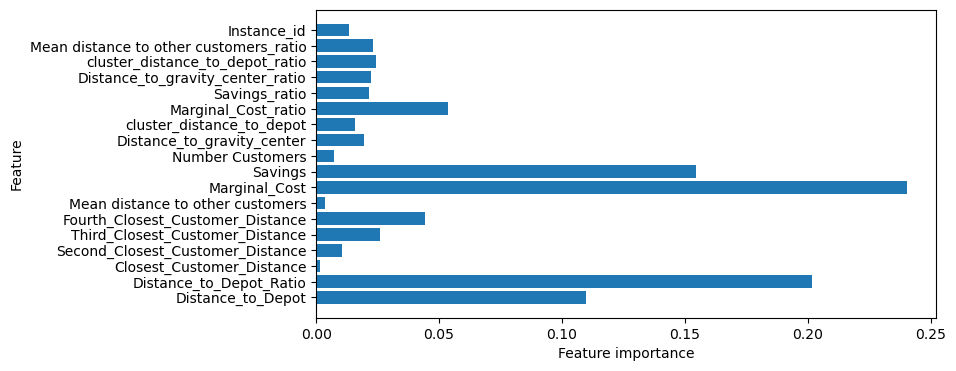

In [5]:
# view feature importances
forest.fit(X_train, y_train)
plot_feature_importances(forest, X_train, all_features=False)

**Gradient Boosting Regression Trees**

In [6]:
# randomized grid search cross validation
param_distributions = {'n_estimators': range(50, 100), 
                       'learning_rate': uniform(0, 0.5), #lower learning rate requires more trees
                       'max_depth': range(1, 25),
                       'max_leaf_nodes': range(1200, 1700)}#,
                       #'min_samples_leaf': range(1, 25),
                       #'max_features': range(15, n_features+1)}

random_grid_search = RandomizedSearchCV(estimator=GradientBoostingRegressor(random_state=0, verbose=False), param_distributions=param_distributions, cv=3,
                                        n_iter=100, scoring='neg_mean_absolute_percentage_error',
                                        random_state=0, n_jobs=-1, verbose=False)
fit_time = fun_fit_gridsearch_time(random_grid_search, X_train, y_train)

# view results of grid search cross validation
MAPE, RMSE = fun_best_model(random_grid_search, X_train, y_train, view_results_df=False, return_scores=True)

# save results to dictionary
results_dict['Gradient Boosting Regression Tree (RGS)'] = {'MAPE': MAPE, 'RMSE': RMSE, 'Fit grid searach time': fit_time, 'Train size': train_size}

  CV MAPE train data: 5.3637 %
  CV RMSE train data: 0.2639

  Best model / parameter combination:
   {'learning_rate': 0.11196234403019006, 'max_depth': 22, 'max_leaf_nodes': 1454, 'n_estimators': 66}


**Create new model with best parameters**

In [7]:
best_params_ = {'n_estimators': 1, #88
               'learning_rate': 0.09057548086845152, 
               'max_depth': 13, 
               'max_leaf_nodes': 1523}

In [8]:
# train new model with best parameter combination but more trees
gbrt = GradientBoostingRegressor(**random_grid_search.best_params_,
                                 random_state=0, verbose=True)

# estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
MAPE, RMSE, computation_time = fun_train_score(gbrt, X_train, y_train, cv=5, return_results=True)

# save results to dictionary
results_dict['Gradient Boosting Regression Tree (Best model)'] = {'MAPE': MAPE, 'RMSE': RMSE, 'CV computation time': computation_time, 'Train size': train_size}

  CV MAPE train data:  5.0921 %
  CV RMSE train data:  1.669
  CV computation time: 7 min, 52 sec


      Iter       Train Loss   Remaining Time 
         1         276.2925            4.53m
         2         219.1277            4.41m
         3         173.8841            4.32m
         4         138.0500            4.26m
         5         109.6853            4.17m
         6          87.2179            4.11m
         7          69.4093            4.03m
         8          55.2966            3.96m
         9          44.0725            3.90m
        10          35.1845            3.83m
        20           4.1544            3.19m
        30           0.7863            2.53m
        40           0.2897            1.87m
        50           0.1546            1.19m
        60           0.0927           27.58s


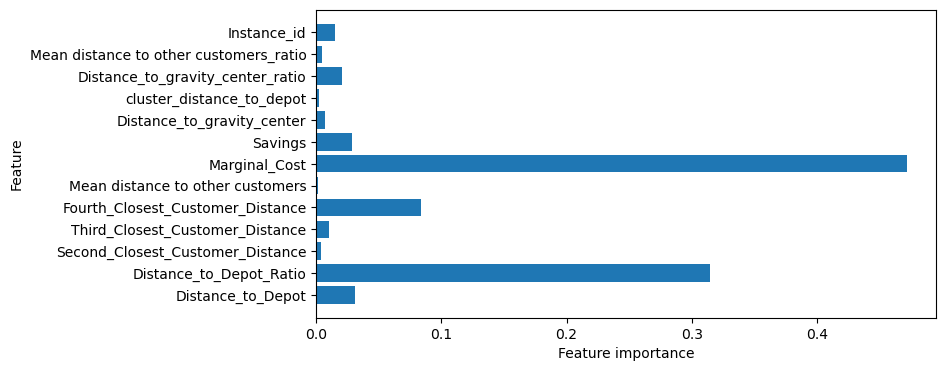

In [9]:
# view feature importances
gbrt.fit(X_train, y_train)
plot_feature_importances(gbrt, X_train, all_features=False)

**Extreme Gradient Boosting: XGBoost-Package**

In [10]:
# create model and fit it on train set (default parameters)
xgboost = xgb.XGBRegressor(objective='reg:squarederror',
                           n_estimators=None, 
                           learning_rate=None,
                           max_depth=None)

# estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
MAPE, RMSE, computation_time = fun_train_score(xgboost, X_train, y_train, cv=10, return_results=True)

# save results to dictionary
results_dict['XGBoost'] = {'MAPE': MAPE, 'RMSE': RMSE, 'CV computation time': computation_time, 'Train size': train_size}

  CV MAPE train data:  5.815300000000001 %
  CV RMSE train data:  1.6959
  CV computation time: 13 sec


# **Compare Results**

In [ ]:
display(pd.DataFrame(results_dict).sort_values(by='MAPE', axis=1))
print('Total script computation time:', fun_convert_time(start=start_script, end=time.time()))

,Gradient Boosting Regression Tree (Best model),Gradient Boosting Regression Tree (RGS),XGBoost,"Random Forest (Best model, more trees)",Random Forest (RGS)
MAPE,5.0921,5.3637,5.8153,7.5048,7.5567
RMSE,1.669,0.2639,1.6959,2.1526,1.7244
Fit grid searach time,NaN,"3 h, 57 min",NaN,NaN,"1 h, 5 min"
CV computation time,"7 min, 52 sec",NaN,13 sec,"3 min, 22 sec",None
Train size,75 %,75 %,75 %,75 %,75 %


Total script computation time: 5 h, 20 min


In [ ]:
import sys
sys.exit("Stop execution")

SystemExit: Stop execution

c:\Users\dennis\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [11]:
display(pd.DataFrame(results_dict).sort_values(by='MAPE', axis=1))
print('Total script computation time:', fun_convert_time(start=start_script, end=time.time()))

,Gradient Boosting Regression Tree (Best model),Gradient Boosting Regression Tree (RGS),XGBoost,"Random Forest (Best model, more trees)",Random Forest (RGS)
MAPE,5.0921,5.3637,5.8153,7.5048,7.5567
RMSE,1.669,0.2639,1.6959,2.1526,1.7244
Fit grid searach time,NaN,"3 h, 57 min",NaN,NaN,"1 h, 5 min"
CV computation time,"7 min, 52 sec",NaN,13 sec,"3 min, 22 sec",None
Train size,75 %,75 %,75 %,75 %,75 %


Total script computation time: 5 h, 20 min
